## Exploring Time Series Trends in Health and Fitness

Leveraging data from Google Trends, this analysis delves into keywords such as 'diet' and 'gym' to uncover how their popularity fluctuates over time. Our goal is to gain insights into the trends and seasonality of time series data related to health and fitness.

### Steps to Insight:

1. **Data Acquisition:** Begin by sourcing your data from reliable repositories or platforms.
2. **Data Preparation:** Tidy your dataset to facilitate analysis, addressing any issues of cleanliness or structure.
3. **Exploratory Data Analysis (EDA):** Dive into the data to uncover initial patterns, anomalies, or insights.
4. **Understanding Trends and Seasonality:**
    - **Trend Analysis:** Examine long-term movements in the data to identify overarching trends.
    - **Seasonality Investigation:**
        - **First Order Differencing:** Use this technique to highlight regular patterns or cycles.
5. **Predictive Modeling:**
    - **Method 1: Naive Approach:** A straightforward method, assuming future values will be the same as the latest data point.
    - **Method 2: Simple Average:** Predict future values based on the average of all past data points.
    - **Method 3: Moving Average:** Utilize the average of recent data points to forecast, allowing for more responsiveness to changes.
    - **Method 4: Single Exponential Smoothing:** Apply weighting factors that decrease exponentially for older data points, offering a refined averaging method that can adapt to trends.

Through this structured approach, we'll explore the dynamics of 'diet' and 'gym' search interests, seeking to understand their behavior over time and forecasting future trends with various statistical methods.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

In [25]:
df = pd.read_csv('data.csv')
df.head()

,Month,diet: (Worldwide),gym: (Worldwide),finance: (Worldwide)
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


In [26]:
df.columns = ['month', 'diet', 'gym', 'finance']
df.head()

,month,diet,gym,finance
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


In [27]:
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)

In [28]:
df.head()

,diet,gym,finance
month,,,
2004-01-01,100,31,48
2004-02-01,75,26,49
2004-03-01,67,24,47
2004-04-01,70,22,48
2004-05-01,72,22,43


## Exploratory Data Analysis (EDA)

**Plotting the data for Diet, Gym and Finance**

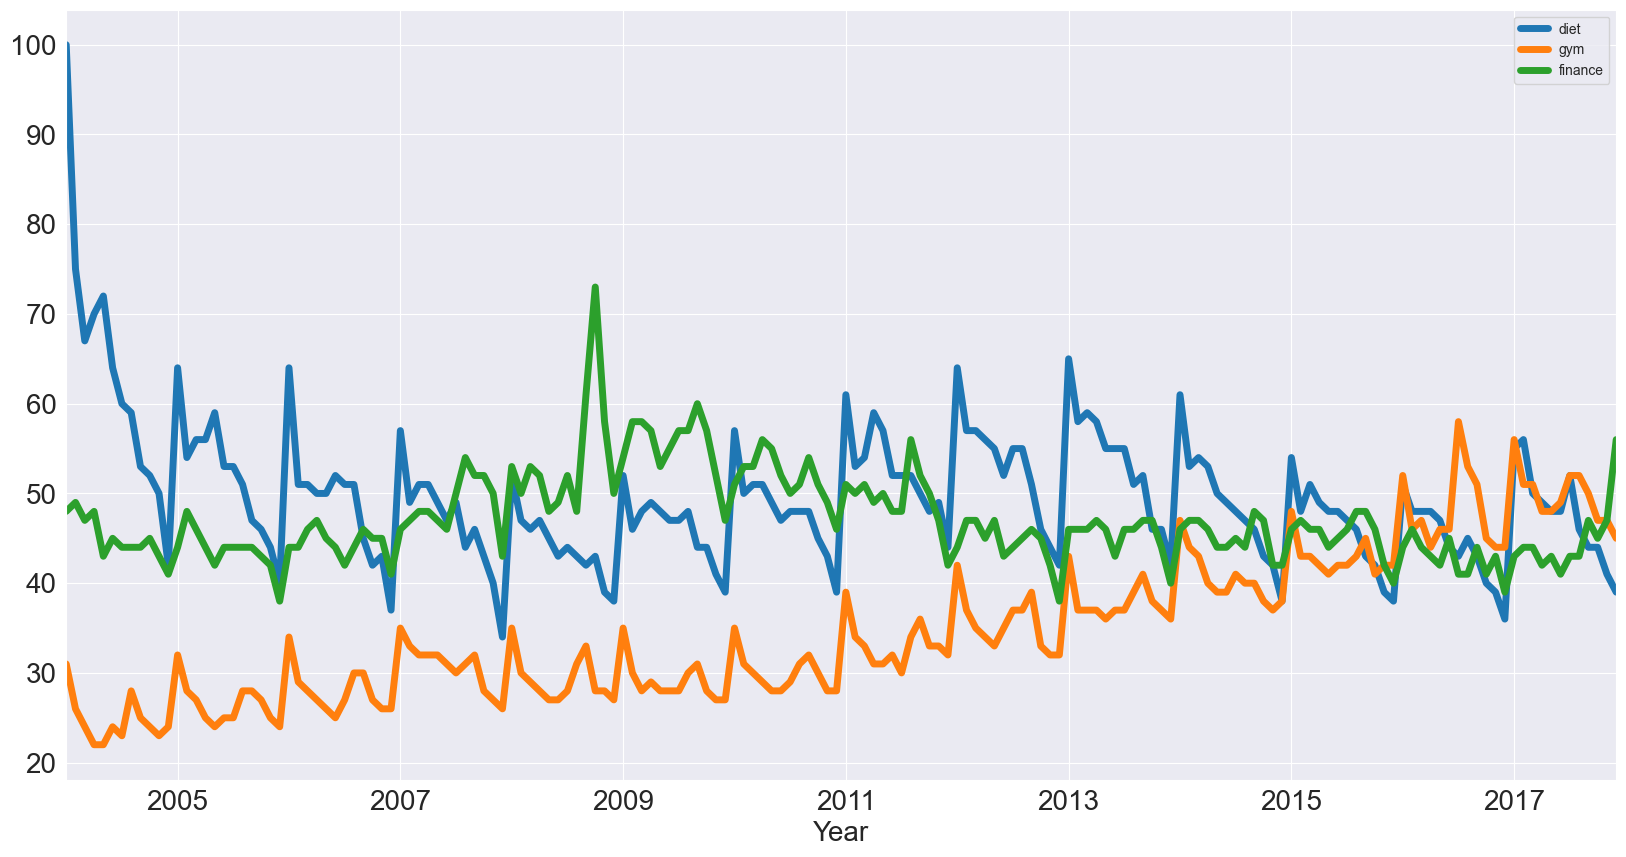

In [29]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

**Plotting for Diet alone**

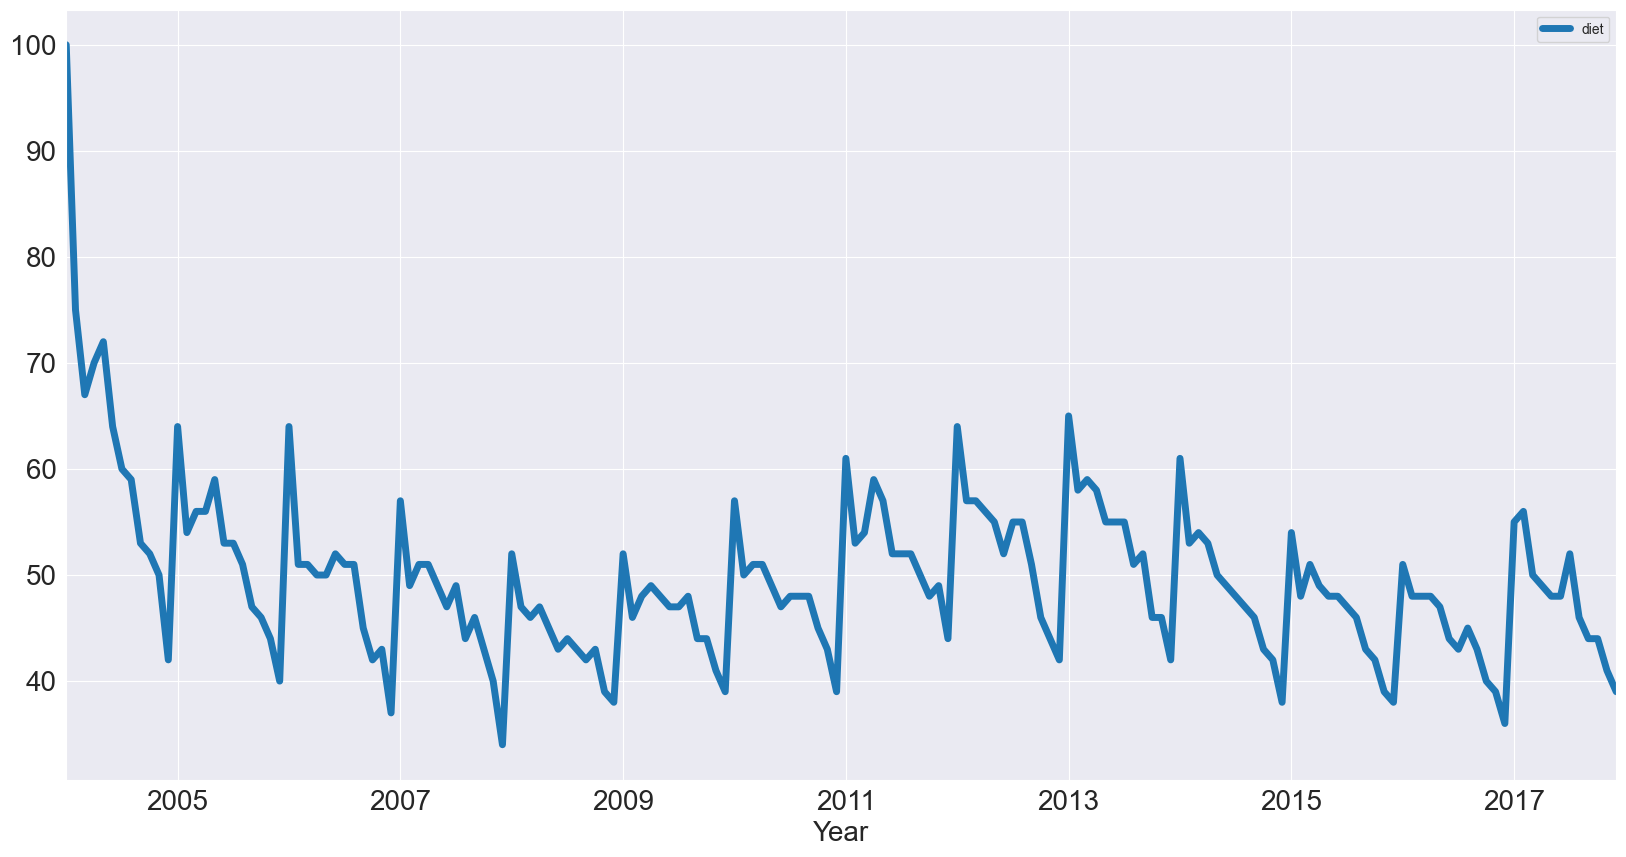

In [30]:
df[['diet']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

### Observation: the first thing to notice is that there is seasonality: each January, there's a big jump. Also, there seems to be a trend: it seems to go slightly up, then down, back up and then back down. In other words, it looks like there are trends and seasonal components to these time series.

## Trends and Seasonality in Time Series Data
### Identifying Trends in Time Series
There are several ways to think about identifying trends in time series. One popular way is by taking a rolling average, which means that, for each time point, you take the average of the points on either side of it. Note that the number of points is specified by a window size, which you need to choose.

When it comes to determining the window size, here, it makes sense to first try out one of twelve months, as you're talking about yearly seasonality.

Text(0.5, 0, 'Year')

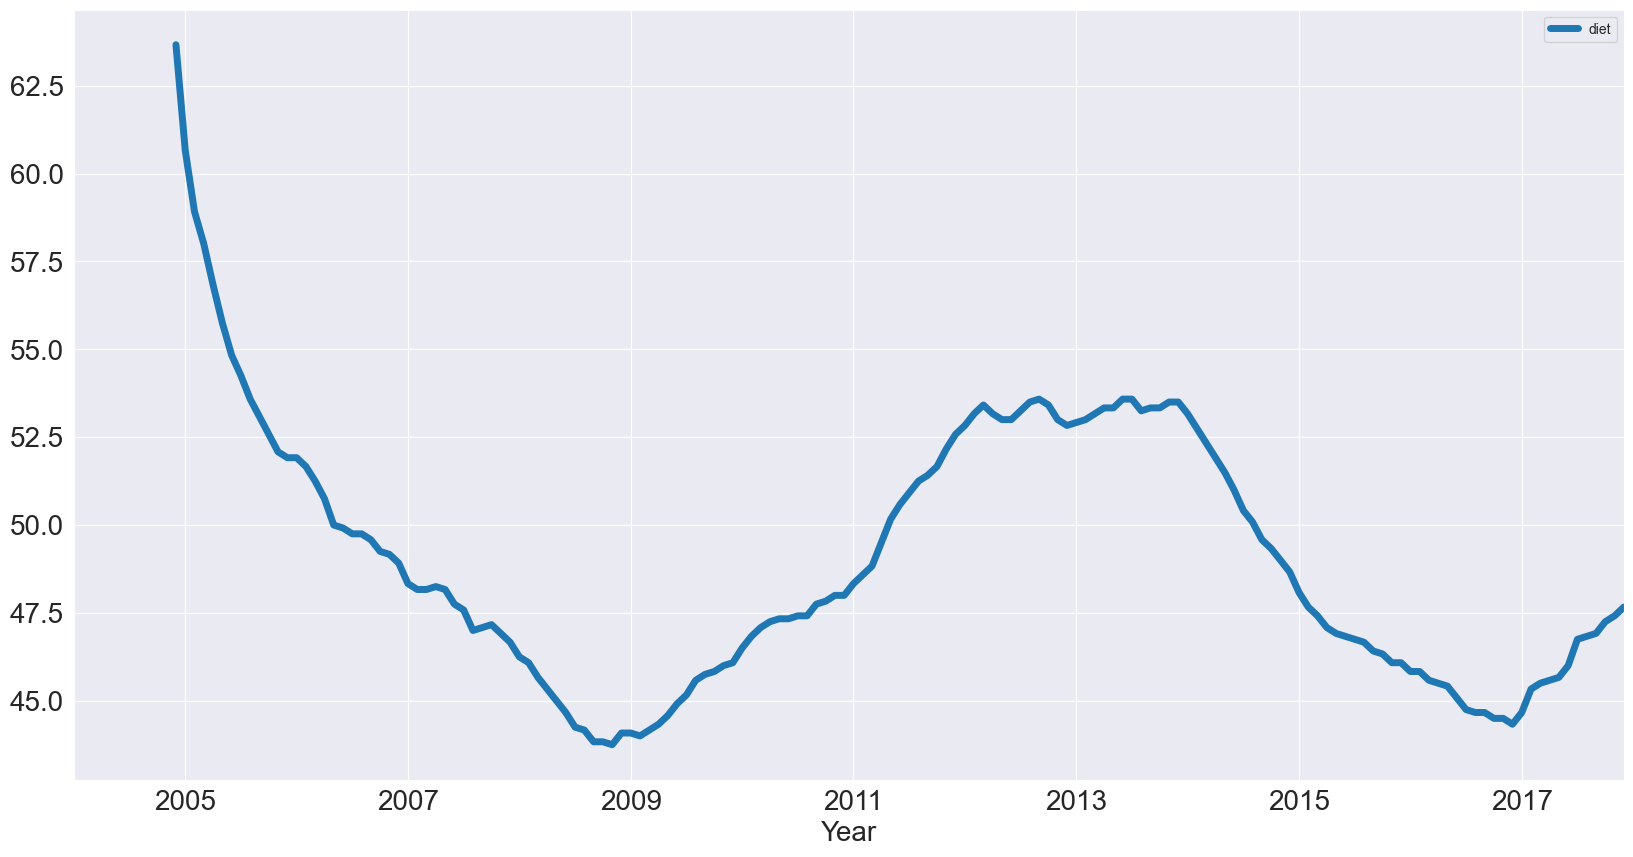

In [31]:
diet = df[['diet']]
diet.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

Now you have the trend that you're looking for! You have removed most of the seasonality compared to the previous plot.

You can also plot the rolling average of 'gym' using built-in pandas methods with the same window size as you took for the 'diet' data:

Text(0.5, 0, 'Year')

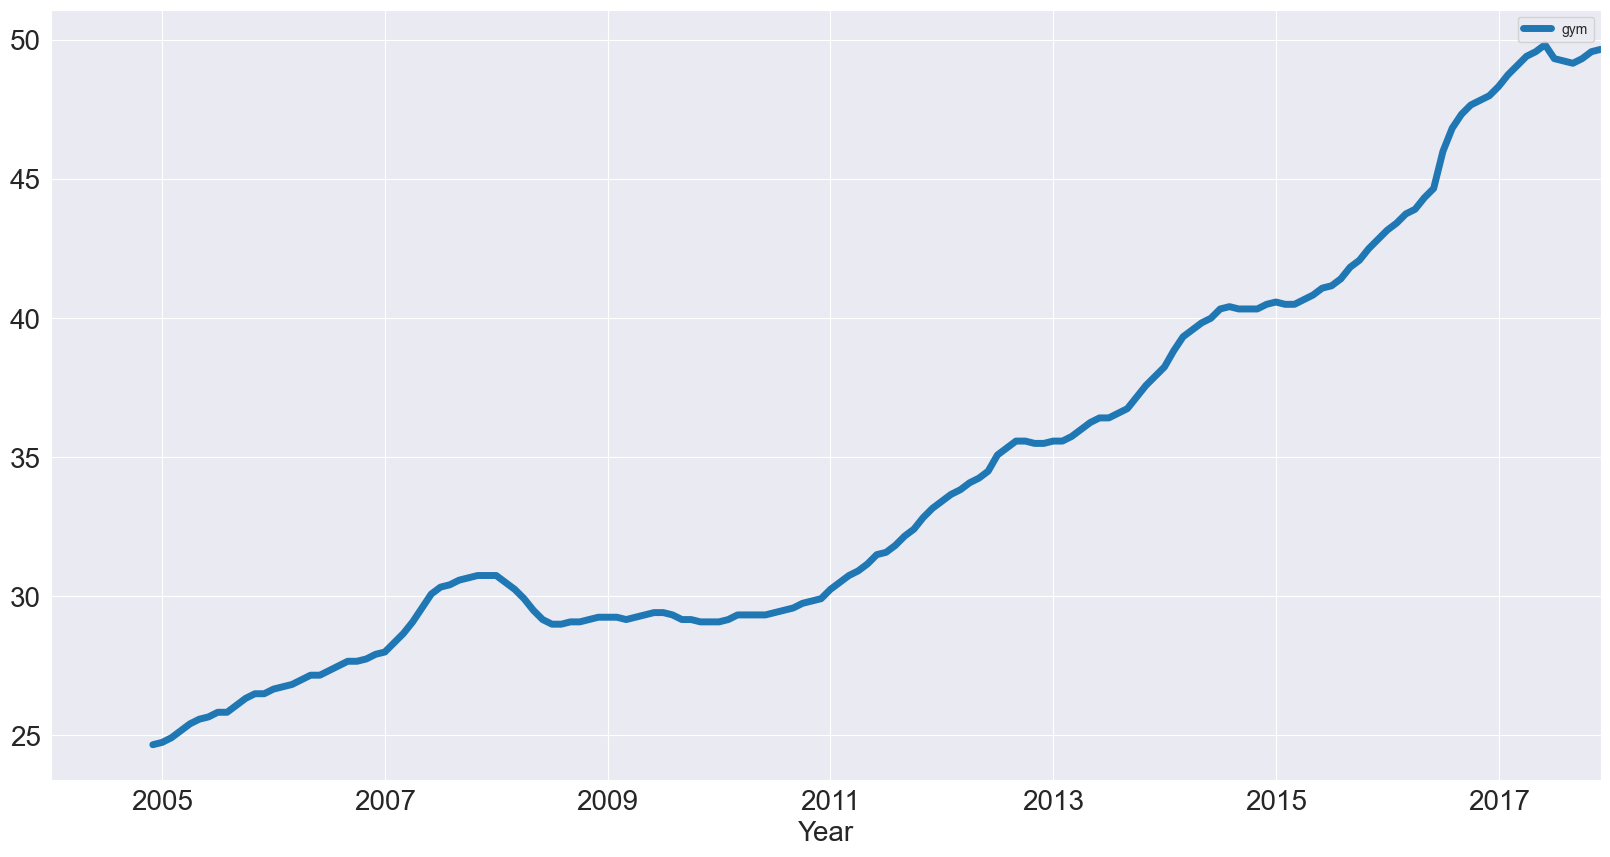

In [32]:
gym = df[['gym']]
gym.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

You have successfully removed the seasonality and you see an upward trend for "gym"! But how do these two search terms compare?

You can figure this out by plotting the trends of 'gym' and 'diet' on a single figure:

Text(0.5, 0, 'Year')

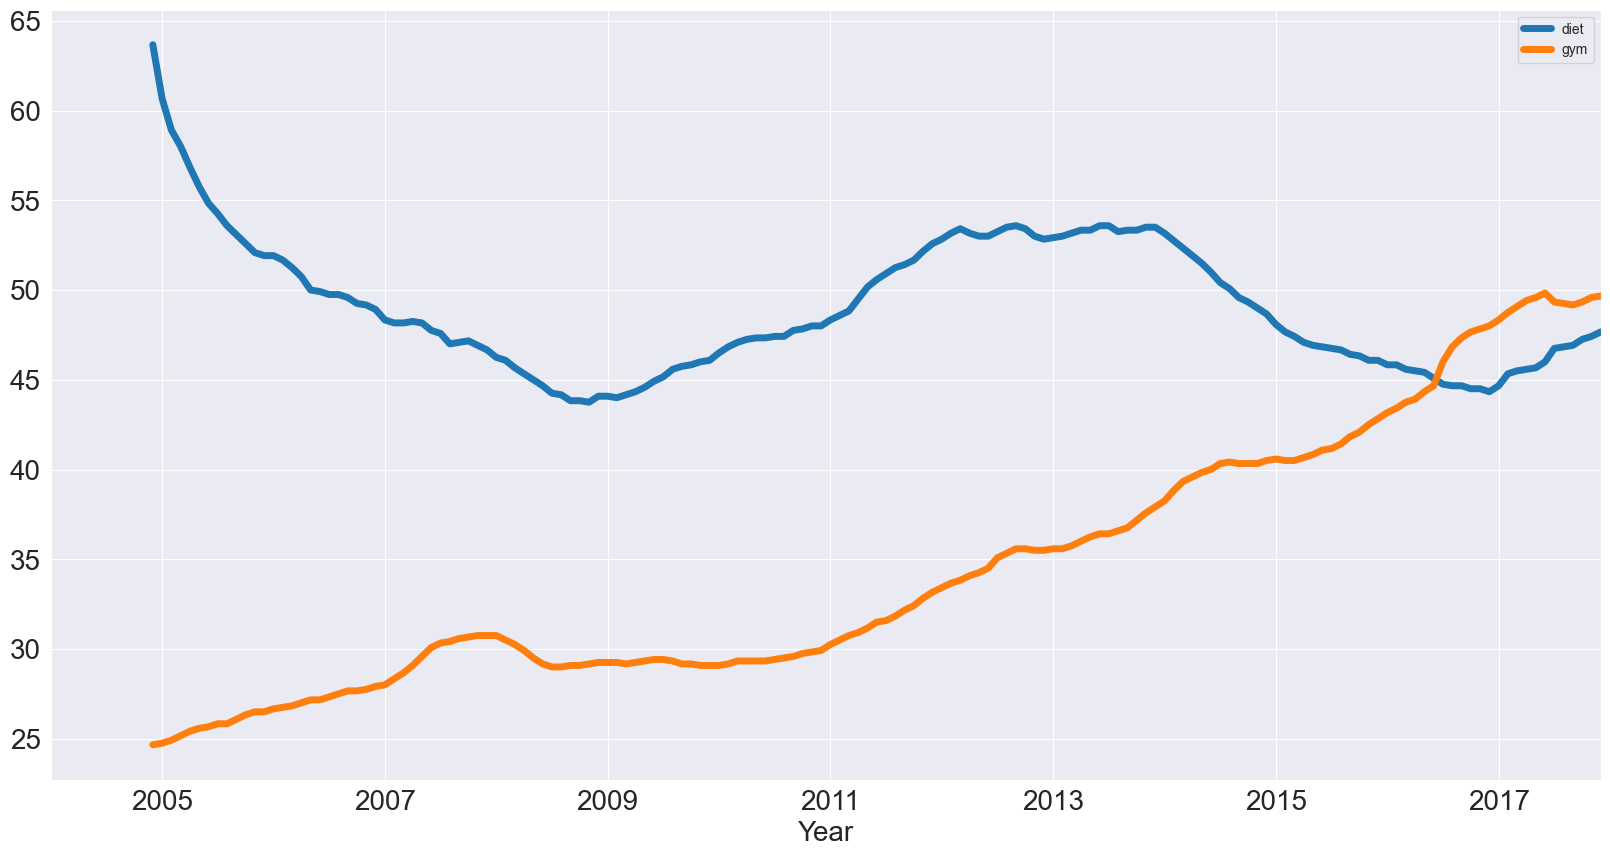

In [33]:
df_rm = pd.concat([diet.rolling(12).mean(), gym.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

With the trends in the data identified, it's time to think about seasonality, which is the repetitive nature of your time series. As you saw in the beginning of this tutorial, it looked like there were trends and seasonal components to the time series of the data

### Seasonal Patterns in Time Series Data

One way to think about the seasonal components to the time series of your data is to remove the trend from a time series, so that you can more easily investigate seasonality. To remove the trend, you can subtract the trend you computed above (rolling mean) from the original signal. This, however, will be dependent on how many data points you averaged over.

Another way to remove the trend is called "differencing", where you look at the difference between successive data points (called "first-order differencing", because you're only looking at the difference between one data point and the one before it).

#### First-order differencing
You can use pandas and the diff() and plot() methods to compute and plot the first order difference of the 'diet' Series:

Text(0.5, 0, 'Year')

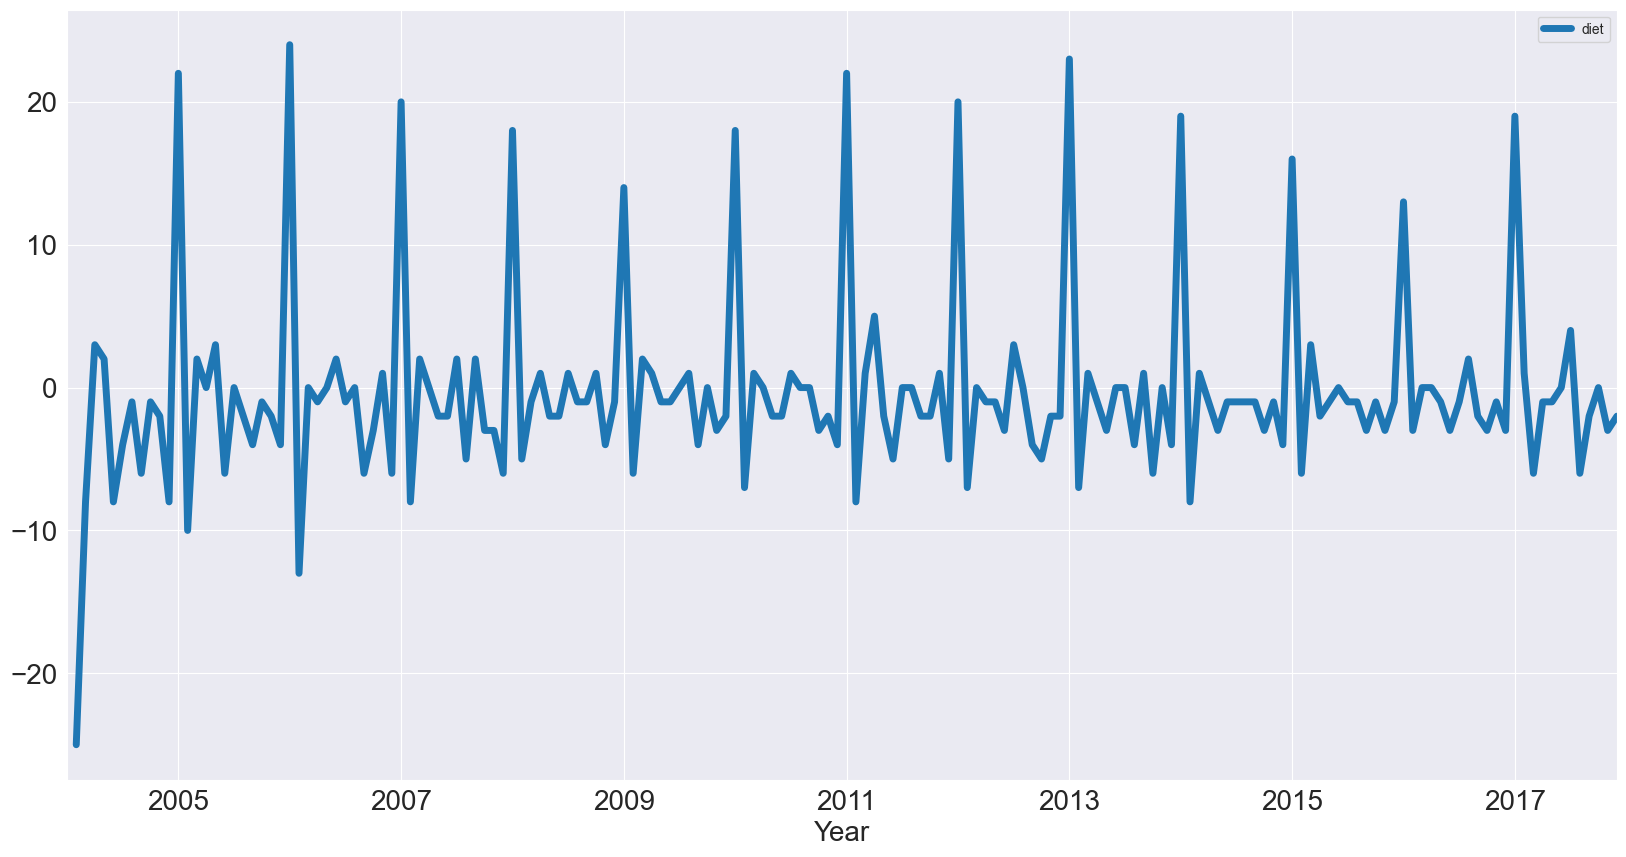

In [34]:
diet.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

See that you have removed much of the trend and you can really see the peaks in January every year. Each January, there is a huge spike of 20 or more percent on the highest search item you've seen!

Note: you can also perform 2nd order differencing, which means that you would be looking at the difference between one data point and the two that precede it, if the trend is not yet entirely removed. See here for more on differencing.

Differencing is super helpful in turning your time series into a stationary time series. You won't get too much into these here but a stationary time series is one whose statistical properties (such as mean and variance) don't change over time. These time series are useful because many time series forecasting methods are based on the assumption that the time series is approximately stationary.

With all of this at hand, you'll now analyze your periodicity in your times series by looking at its autocorrelation function.

## Forecasting

1. Method 1 – Start with a Naive Approach
2. Method 2 – Simple average
3. Method 3 – Moving average
4. Method 4 – Single Exponential smoothing

We will be using the Gym portion of the dataset

In [35]:
gym = df[['gym']].copy()
gym['gym'] = gym['gym'].astype(np.float64)

In [36]:
train = gym[gym.index.year < 2017]
test = gym[gym.index.year == 2017]

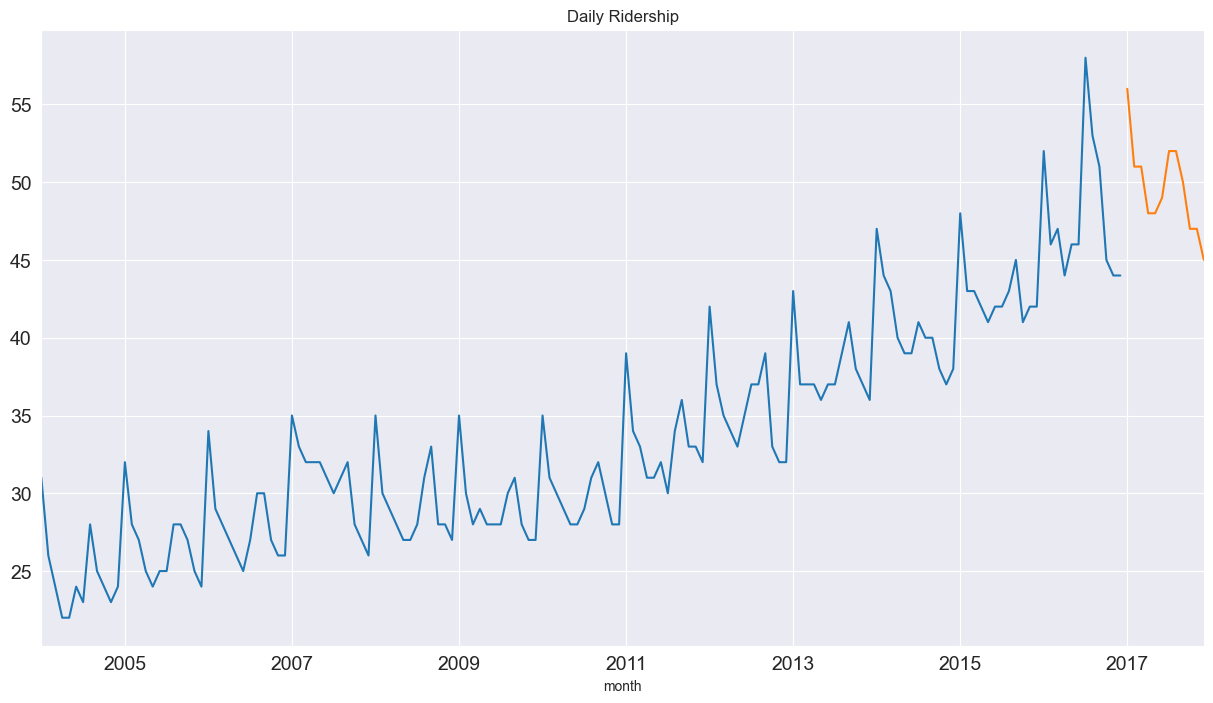

In [37]:
train.gym.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.gym.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

### Method 1: Start with a Naive Approach

We can simply take the last day value and estimate the same value for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called **Naive Method**.

$\(\hat{y}\)_\(t+1\) = y_t$

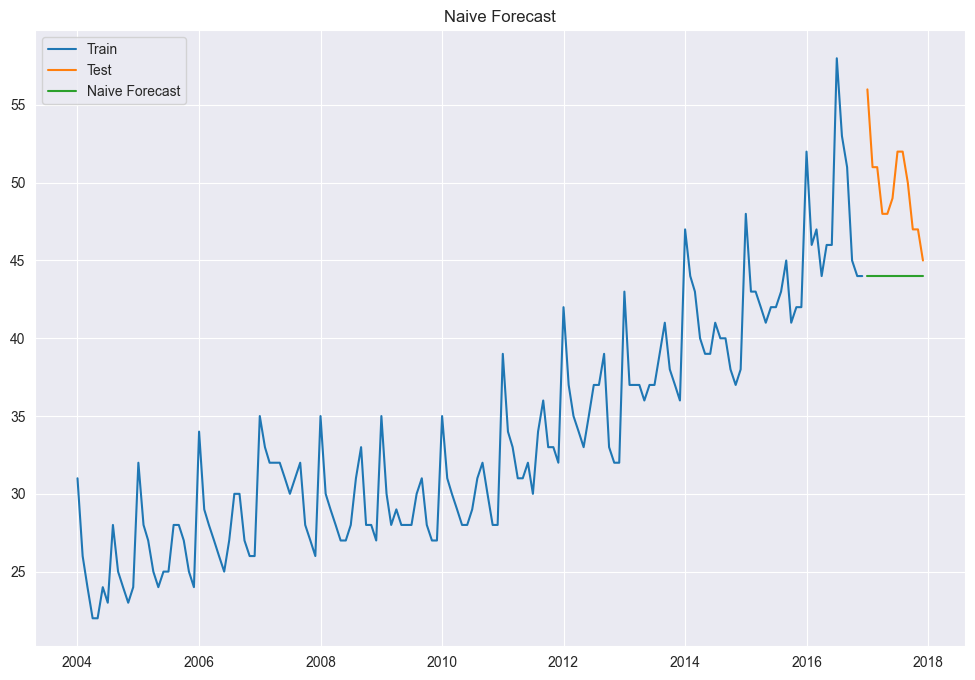

In [38]:
dd= np.asarray(train.gym)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize=(12,8))
plt.plot(train.index, train['gym'], label='Train')
plt.plot(test.index,test['gym'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

We will now calculate RMSE to check to accuracy of our model on test data set.

In [39]:
rms = sqrt(mean_squared_error(test.gym, y_hat.naive))
print(rms)

6.3377177806105145


We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. Now we will look at another technique and try to improve our score.

### Method 2: – Simple Average

Many a times we are provided with a dataset, which though varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

Such forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

$\(\hat{y}\)_\(t+1\) = \frac{1}{len(y)} * sum(y)$

We take all the values previously known, calculate the average and take it as the next value. Of course it won’t be it exact, but somewhat close. As a forecasting method, there are actually situations where this technique works the best.

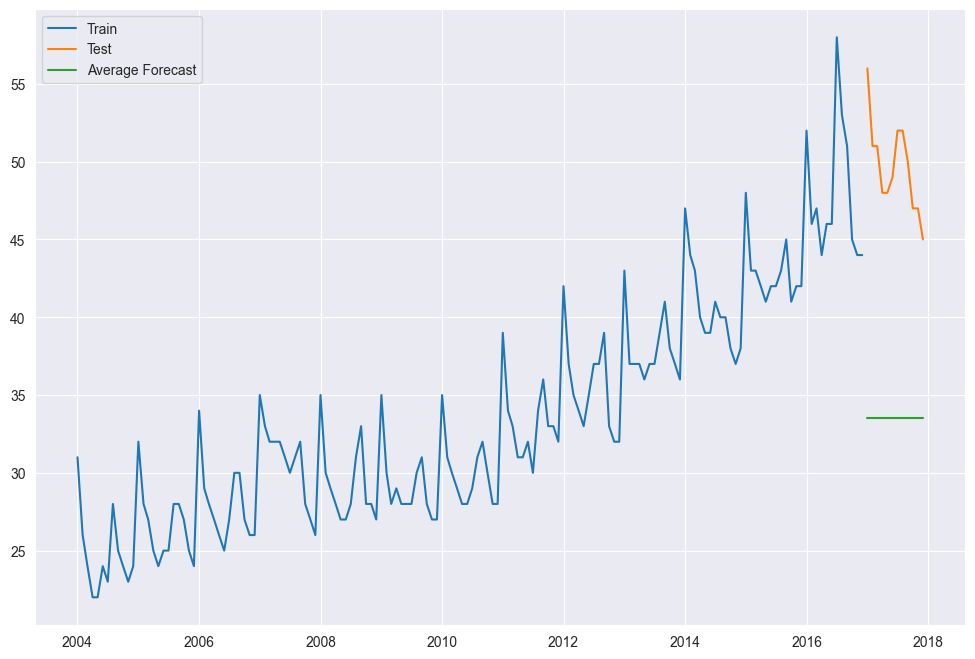

In [47]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['gym'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['gym'], label='Train')
plt.plot(test['gym'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [48]:
rms = sqrt(mean_squared_error(test.gym, y_hat_avg.avg_forecast))
print(rms)

16.37603603479846


We can see that this model didn’t improve our score. Hence we can infer from the score that this method works best when the average at each time period remains constant. Though the score of Naive method is better than Average method, but this does not mean that the Naive method is better than Average method on all datasets. We should move step by step to each model and confirm whether it improves our model or not.

### Method 3 – Moving Average

Many a times we are provided with a dataset, in which the prices/sales of the object increased/decreased sharply some time periods ago. In order to use the  previous Average method, we have to use the mean of all the previous data, but using all the previous data doesn’t sound right.

Using the prices of the initial period would highly affect the forecast for the next period. Therefore, as an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

Using a simple moving average model, we forecast the next value(s) in a time series based on the average of a fixed finite number ‘p’ of the previous values. Thus, for all i > p

$\(\hat{y}\)_l = \frac{1}{p} * (y_\(t-1\) + y_\(t-2\) + y_\(t-3\) + y_\(t-4\) + ... +y_\(t-p\))$

A moving average can actually be quite effective, especially if you pick the right p for the series. We choose a p of 12 here because we want the yearly forecast.

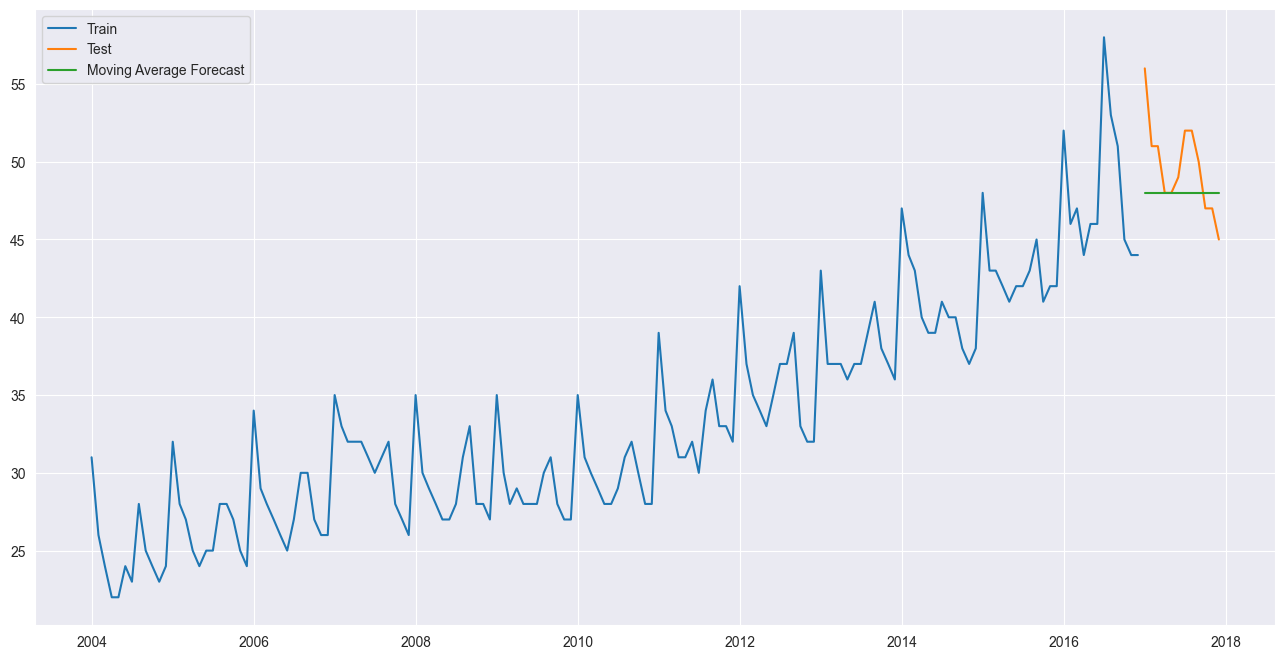

In [42]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['gym'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['gym'], label='Train')
plt.plot(test['gym'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [43]:
rms = sqrt(mean_squared_error(test.gym, y_hat_avg.moving_avg_forecast))
print(rms)

3.2914029430219167


We can see that Moving average so far has the best performance for this dataset. Now we will look at Simple Exponential Smoothing method and see how it performs.

### Method 4 – Simple Exponential Smoothing

It may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:
<br/>

$\hat{y}_{t} = \alpha y_t + (1 - \alpha) \hat{y}_{t-1}$

where 0 <= alpha <=1 is the smoothing parameter.

So essentially we’ve got a weighted moving average with two weights: α and 1−α.

As we can see, 1−α is multiplied by the previous expected value ŷ, which makes the expression recursive. And this is why this method is called 'Exponential'. The forecast at time t+1 is equal to a weighted average between the most recent observation $y_t$ and the most recent forecast $ŷ_{t−1}$.

In [44]:
test['gym']

month
2017-01-01    56.0
2017-02-01    51.0
2017-03-01    51.0
2017-04-01    48.0
2017-05-01    48.0
2017-06-01    49.0
2017-07-01    52.0
2017-08-01    52.0
2017-09-01    50.0
2017-10-01    47.0
2017-11-01    47.0
2017-12-01    45.0
Name: gym, dtype: float64

46.812872613943284 56.0
3.345584748921188


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6872\881932019.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ft, test['gym'][0])
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6872\881932019.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = test['gym'][i-1]


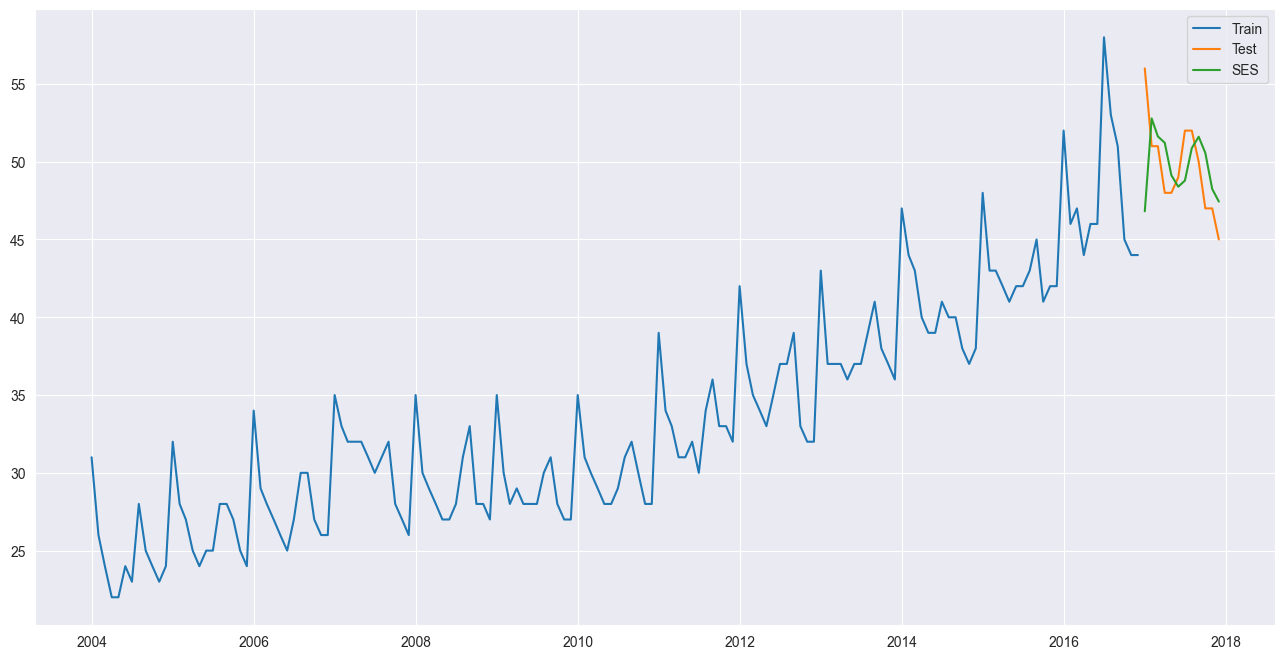

In [45]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

y_hat_avg = test.copy()

pred = []
#s = 9
a = 0.65
#a = 2/(s+1)
#ft = pd.DataFrame.ewm(train, alpha = a).mean()['gym'][-1]
ft = pd.DataFrame.ewm(train, span = 10).mean()['gym'].iloc[-1]
#ft = train['gym'].mean()
pred.append(ft)
print(ft, test['gym'][0])
for i in range(1,len(test['gym'])):
    dt = test['gym'][i-1]
    ft_plus_1 = a*dt + (1-a)*ft
    #print(i, dt, ft, ft_plus_1)
    pred.append(ft_plus_1)
    ft = ft_plus_1
y_hat_avg['SES'] = pd.Series(pred).values

rms = sqrt(mean_squared_error(test.gym, y_hat_avg.SES))
print(rms)

plt.figure(figsize=(16,8))
plt.plot(train['gym'], label='Train')
plt.plot(test['gym'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [46]:
rms = sqrt(mean_squared_error(test.gym, y_hat_avg.SES))
print(rms)

3.345584748921188


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.


#### Exercise: Research the ARIMA model